In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.stats_maker import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
merged = pd.read_csv('../../data/housing2019.csv')

In [4]:
lst = []
for i in sorted(merged.columns):
    lst.append(i)
#lst

In [5]:
merged['Sqft'] = merged['SqFtTotLiving'] + merged['SqFtFinBasement'] + merged['SqFtDeck']
trimmed = merged[(merged['SqFtTotLiving'] < 50000) & (merged['SqFtTotLiving'] > 10)]
sqft = trimmed['SqFtTotLiving']
price = trimmed['SalePrice']

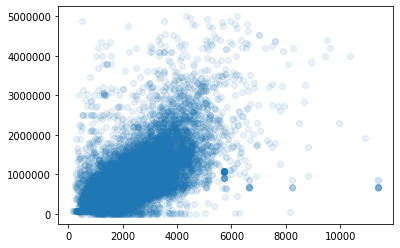

In [125]:
x = np.linspace(0, 10000, num = 1000)
y = x * 187.7 + 1.248 * 10 ** 4
plt.scatter(sqft, price, alpha = 0.1)
# plt.plot(x, y, color = 'r')

In [135]:
fsm = get_model(trimmed, ['SqFtTotLiving'])
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                 1.553e+04
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        15:09:55   Log-Likelihood:            -4.2546e+05
No. Observations:               29614   AIC:                         8.509e+05
Df Residuals:                   29612   BIC:                         8.509e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.227e+05   5817.404     21.090      0.000    1.11e+05    1.34e+05
SqFtTotLiving   304.3329      2.442    124.619      0.000     299.546     309.120
==============================================================================
Omnibus:                    15527.502   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           230600.662
Skew:                           2.181   Prob(JB):                         0.00
Kurtosis:                      15.956   Cond. No.                     5.68e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [136]:
get_rainbow(fsm)

{'statistic': 1.0373485238694378, 'p-value': 0.012847997305641927}

In [26]:
def compare_to_transform(df, column, function):
    fig, ax = plt.subplots(1, 2)
    series = df[column]
    ax[0].hist(series, bins = 40, alpha = 0.9)
    ax[0].set_title(column)
    ax[0].set_xlabel(column)
    ax[1].hist(series[series > 0].apply(function), bins = 40, alpha = 0.9)
    ax[1].set_title('Log(' + column + ")")
    ax[1].set_xlabel('Log(' + column + ")");

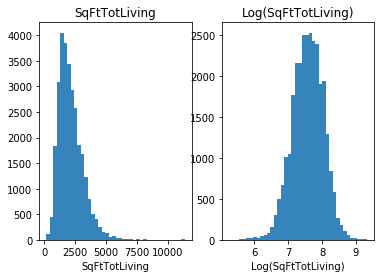

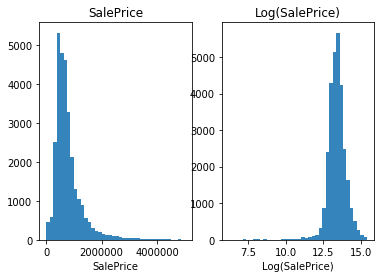

In [27]:
compare_to_transform(trimmed, 'SqFtTotLiving', math.log)
compare_to_transform(trimmed, 'SalePrice', math.log)

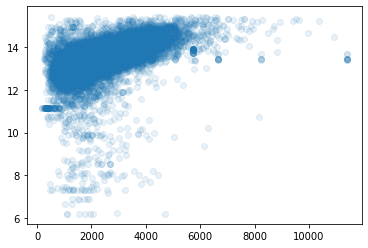

In [63]:
plt.scatter(sqft, price.apply(math.log), alpha = 0.1)

In [43]:
log_df = trimmed.copy()
log_df['SalePrice'] = log_df['SalePrice'].apply(math.log)
log_df['SqFtTotLiving'] = log_df['SqFtTotLiving'].apply(math.log)

In [44]:
log_sqft = trimmed['SqFtTotLiving'].apply(math.log)
log_jb = (log_sqft.skew() ** 2 + .25 *(log_sqft.kurtosis() - 3) ** 2) * len(log_sqft) / 6

sqft = trimmed['SqFtTotLiving']
jb = (sqft.skew() ** 2 + .25 *(sqft.kurtosis() - 3) ** 2) * len(sqft) / 6
print('JB of sqft: ' + str(jb), '\nJB of Log(sqft):' + str(log_jb))

JB of sqft: 16760.131306131672 
JB of Log(sqft):8880.10860830138


Text(0.5, 1.0, 'Error of log model')

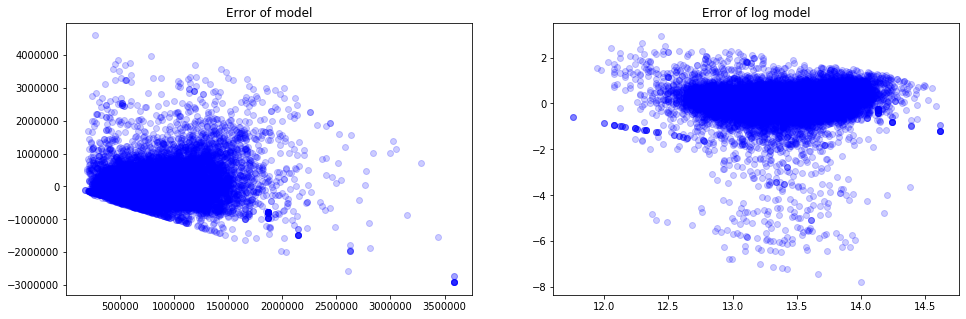

In [56]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
y = trimmed['SalePrice']
y_hat = get_model(trimmed, ['SqFtTotLiving']).predict()
ax[0].scatter(x=y_hat, y=y-y_hat, color="blue", alpha=0.2)
ax[0].set_title('Error of model')

y = log_df['SalePrice']
y_hat = get_model(log_df, ['SqFtTotLiving']).predict()
ax[1].scatter(x=y_hat, y=y-y_hat, color="blue", alpha=0.2)
ax[1].set_title('Error of log model')


In [131]:
merged = merged.drop(labels = 'Unnamed: 0', axis = 1)

In [103]:
lst = []
for i in merged.columns:
    for j in merged.columns:
        if i == j: continue  
        try:
            rows = merged[[i, j]].values

            vif_df = pd.DataFrame()
            vif_df["VIF"] = [variance_inflation_factor(rows, k) for k in range(2)]
            vif_df["feature"] = [i, j]

            lst.append(vif_df)
            break
        except:
            pass

In [6]:
# this if for cutting the df down to only things that have valid vif's and drops a bunch of other stuff
# not sure why I did this. I think its kinda dumb
# It also aggregates waterfront columns and view columns into 1
dfi = lst[0]
for i in lst[1:]:
    dfi = pd.concat([dfi, i], axis = 0)
vif_able_columns = dfi['feature'].unique()
df_vif_only = merged[vif_able_columns]

df_vif_only['Wfnt'] = ((df_vif_only['WfntLocation'] != 0)
                        + (df_vif_only['WfntFootage'] != 0)
                        + (df_vif_only['WfntBank'] != 0)
                        + (df_vif_only['WfntPoorQuality'] != 0)
                        + (df_vif_only['WfntRestrictedAccess'] != 0)).astype(int)
df_vif_only = df_vif_only.drop(labels = ['WfntLocation', 'WfntFootage', 'WfntBank', 'WfntPoorQuality', 'WfntRestrictedAccess'], axis = 1)

view_cols = ['MtRainier', 'Olympics', 'Cascades', 'Territorial', 'SeattleSkyline', 'PugetSound', 'LakeWashington', 'LakeSammamish', 'SmallLakeRiverCreek', 'OtherView']
view_series = pd.Series(np.zeros(df_vif_only.shape[0]))
for i in view_cols:
    view_series = view_series + df_vif_only[i]
view_series = view_series.astype(int)
df_vif_only['ViewNumber'] = view_series
df_vif_only = df_vif_only.drop(view_cols, axis = 1)

#Get rid of some sqft columns i dont want
sqft_cols = ['SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor', 'SqFtUpperFloor', 'SqFtUnfinFull',
             'SqFtUnfinHalf', 'SqFtFinBasement', 'FinBasementGrade', 'SqFtGarageBasement']
df_vif_only = df_vif_only.drop(sqft_cols, axis = 1)

#Get rid of locational IDs
location_cols = ['Range',
                 #'Township',
                 'Section',
                 #'Area',
                 'SubArea',
                 'LevyCode']
df_vif_only = df_vif_only.drop(location_cols, axis = 1)


other_cols = ['Major_x', 'Minor_x', 'HBUAsIfVacant', 'HBUAsImproved', 'PresentUse', 'Major_y', 'Minor_y', 'Major', 'Minor']
df_vif_only = df_vif_only.drop(other_cols, axis = 1)
df_vif_only.columns

TypeError: cannot concatenate object of type '<class 'str'>'; only Series and DataFrame objs are valid

In [21]:
using_columns = ['Wfnt', 'ViewNumber', 'SqFtTotLiving', 'SqFtOpenPorch',
                          'SqFtEnclosedPorch', 'SqFtDeck', 'Bedrooms', 'BathHalfCount',
                          'Bath3qtrCount', 'BathFullCount',
                          'TrafficNoise', 'Stories', 'Condition', 'Area',
                          'WaterSystem', 'SewerSystem', 'YrBuilt',
                          'YrRenovated', 'BldgGrade', 'Township']
#two = stats_of_combinations(trimmed, 1)
#two = stats_of_combinations(df_vif_only, 2, using_columns)
#three = stats_of_combinations(df_vif_only, 3, using_columns)
#four = stats_of_combinations(df_vif_only, 4, using_columns)
#srtd = sort_by_r2(two)

In [200]:
srtd = sort_by_r2(four)
fltrd = filter_vf(srtd)

In [217]:
deef = pd.DataFrame()
for i in range(500):
    deef = deef.append(fltrd[i]['columns'])

In [218]:
deef[0].value_counts()

ViewNumber           225
SqFtOpenPorch        176
Bath3qtrCount        164
SqFtDeck             147
SqFtTotLiving        144
BathHalfCount        139
Wfnt                 136
YrRenovated          134
TrafficNoise         129
SqFtEnclosedPorch    129
BldgGrade            112
Area                 110
Township             100
BathFullCount         76
Condition             24
Bedrooms              19
Stories               17
SewerSystem           13
YrBuilt                3
WaterSystem            3
Name: 0, dtype: int64

In [216]:
fltrd[0]['ols'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     5203.
Date:                Wed, 04 Mar 2020   Prob (F-statistic):               0.00
Time:                        15:07:09   Log-Likelihood:            -4.2392e+05
No. Observations:               29621   AIC:                         8.479e+05
Df Residuals:                   29616   BIC:                         8.479e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.084e+06   1.58e+04    -68.425      0.000   -1.12e+06   -1.05e+06
ViewNumber     5.122e+04   1269.954     40.335      0.000    4.87e+04    5.37e+04
SqFtOpenPorch   394.5357     16.622     23.736      0.000     361.956     427.115
YrRenovated     115.8348      5.613     20.636      0.000     104.833     126.837
BldgGrade      2.334e+05   2095.289    111.404      0.000    2.29e+05    2.38e+05
==============================================================================
Omnibus:                    16664.013   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           267788.762
Skew:                           2.373   Prob(JB):                         0.00
Kurtosis:                      16.945   Cond. No.                     2.94e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.94e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [124]:
merg_cop = merged.copy()
using_columns = ['TrafficNoise', 'AirportNoise', 'PowerLines', 'OtherNuisances']
merg_cop["PowerLines"] = (merg_cop["PowerLines"] == 'Y').astype(int)
merg_cop['OtherNuisances'] = (merg_cop['OtherNuisances'] == 'Y').astype(int)
combo_stats = stats_of_combinations(merg_cop, 4, using_columns)
len(combo_stats)

Combinations to go through: 1
Percent Done: 100


1

In [125]:
combo_stats = sort_by_r2(combo_stats)
for i in combo_stats:
    print(i['ols'].rsquared)

0.00047502233539975514
